# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans




# Import Dataset

In [3]:
raw_SPY_intraday_df = pd.read_csv("../Data/SPY_intraday_polygon_2024_2025.csv")

# Data Cleaning

In [4]:
raw_SPY_intraday_df.head()

,timestamp_utc,open,high,low,close,volume,vwap,ret,vol_5m,vol_30m
0,2024-01-02 09:00:00+00:00,476.25,476.36,476.00,476.31,20460.0,476.2997,NaN,NaN,NaN
1,2024-01-02 09:01:00+00:00,476.34,476.34,476.29,476.29,6369.0,476.3201,-0.000042,NaN,NaN
2,2024-01-02 09:02:00+00:00,476.29,476.29,476.28,476.28,6152.0,476.2802,-0.000021,NaN,NaN
3,2024-01-02 09:03:00+00:00,476.27,476.27,476.27,476.27,369.0,476.2701,-0.000021,NaN,NaN
4,2024-01-02 09:05:00+00:00,476.20,476.20,476.19,476.20,547.0,476.1955,-0.000147,NaN,NaN


In [5]:
# Create copy of raw dataframe
SPY_intraday_df = raw_SPY_intraday_df.copy()

## Check data types

In [6]:
SPY_intraday_df.dtypes

timestamp_utc     object
open             float64
high             float64
low              float64
close            float64
volume           float64
vwap             float64
ret              float64
vol_5m           float64
vol_30m          float64
dtype: object

### Convert timestamps

In [7]:
# Convert timestamp
SPY_intraday_df['timestamp_utc'] = pd.to_datetime(SPY_intraday_df['timestamp_utc'], utc=True)


## Check for missing values

In [8]:
SPY_intraday_df.isna().sum()


timestamp_utc     0
open              0
high              0
low               0
close             0
volume            0
vwap              0
ret               1
vol_5m            5
vol_30m          30
dtype: int64

In [9]:
SPY_intraday_df[SPY_intraday_df.isna().any(axis=1)]

,timestamp_utc,open,high,low,close,volume,vwap,ret,vol_5m,vol_30m
0,2024-01-02 09:00:00+00:00,476.25,476.36,476.00,476.31,20460.0,476.2997,NaN,NaN,NaN
1,2024-01-02 09:01:00+00:00,476.34,476.34,476.29,476.29,6369.0,476.3201,-0.000042,NaN,NaN
2,2024-01-02 09:02:00+00:00,476.29,476.29,476.28,476.28,6152.0,476.2802,-0.000021,NaN,NaN
3,2024-01-02 09:03:00+00:00,476.27,476.27,476.27,476.27,369.0,476.2701,-0.000021,NaN,NaN
4,2024-01-02 09:05:00+00:00,476.20,476.20,476.19,476.20,547.0,476.1955,-0.000147,NaN,NaN
5,2024-01-02 09:06:00+00:00,476.18,476.18,476.18,476.18,230.0,476.1778,-0.000042,0.000053,NaN
6,2024-01-02 09:07:00+00:00,476.21,476.21,476.14,476.14,5624.0,476.1469,-0.000084,0.000054,NaN
7,2024-01-02 09:08:00+00:00,476.19,476.19,476.19,476.19,107.0,476.1895,0.000105,0.000093,NaN
8,2024-01-02 09:10:00+00:00,476.13,476.13,476.12,476.12,340.0,476.1294,-0.000147,0.000104,NaN
9,2024-01-02 09:11:00+00:00,476.03,476.03,476.02,476.03,341.0,476.0236,-0.000189,0.000114,NaN


Missing values are the first 45mins in the range of the price history as the window of time has not been formed yet to calculate the 5m and 30m rolling volatility and also return. Dont know why its missing from 9:30-9:45, but will be dropped anyways probably when filtering for the date range.

## Check for consistent frequency

In [10]:
diffs = SPY_intraday_df['timestamp_utc'].diff().value_counts().sort_index()
print(diffs.head(10))


timestamp_utc
0 days 00:01:00    330643
0 days 00:02:00     19489
0 days 00:03:00      7235
0 days 00:04:00      3229
0 days 00:05:00      1685
0 days 00:06:00       957
0 days 00:07:00       583
0 days 00:08:00       388
0 days 00:09:00       243
0 days 00:10:00       146
Name: count, dtype: int64


- The time interval analysis shows that most data points (`≈330,000 rows`) are spaced exactly **1 minute apart**, indicating generally consistent intraday sampling.
- However, there are a significant number of longer gaps:
  - `~19,000` rows have **2-minute gaps**
  - Smaller counts for gaps of **3–10 minutes**, progressively fewer as the gap increases.
- This suggests that the dataset is **not perfectly minute-consistent**, and there are periods where 1 or more minutes of data are missing.
- Such gaps are typical in **intraday financial data** due to:
  - Non-trading periods (overnight, weekends)
  - Low activity or missing ticks in pre/post-market hours
  - Occasional missing bars from the data provider
- Before performing time-based calculations (e.g., rolling volatility or model training), it may be necessary to **reindex to a complete 1-minute frequency** and **forward-fill** missing values to ensure even time steps.


### Forward-fill index

In [11]:
SPY_intraday_df = SPY_intraday_df.set_index('timestamp_utc')

# Create full 1-minute date range
full_index = pd.date_range(
    start=SPY_intraday_df.index.min(),
    end=SPY_intraday_df.index.max(),
    freq='1min'
)

# Reindex and forward-fill
SPY_intraday_df = SPY_intraday_df.reindex(full_index)
SPY_intraday_df.ffill(inplace=True)

# Reset index and rename
SPY_intraday_df.reset_index(inplace=True)
SPY_intraday_df.rename(columns={'index': 'timestamp_utc'}, inplace=True)

# Verify
print(SPY_intraday_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 949860 entries, 0 to 949859
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   timestamp_utc  949860 non-null  datetime64[ns, UTC]
 1   open           949860 non-null  float64            
 2   high           949860 non-null  float64            
 3   low            949860 non-null  float64            
 4   close          949860 non-null  float64            
 5   volume         949860 non-null  float64            
 6   vwap           949860 non-null  float64            
 7   ret            949859 non-null  float64            
 8   vol_5m         949854 non-null  float64            
 9   vol_30m        949813 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(9)
memory usage: 72.5 MB
None


## Validate Trading Hours

Do i need to do this?

In [12]:
# Filter regular U.S. trading hours only (14:30–21:00 UTC, weekdays)
SPY_intraday_df = SPY_intraday_df[
    (SPY_intraday_df['timestamp_utc'].dt.time >= pd.to_datetime("14:30").time()) &
    (SPY_intraday_df['timestamp_utc'].dt.time <= pd.to_datetime("21:00").time()) &
    (SPY_intraday_df['timestamp_utc'].dt.dayofweek < 5)
]

## Check for outliers

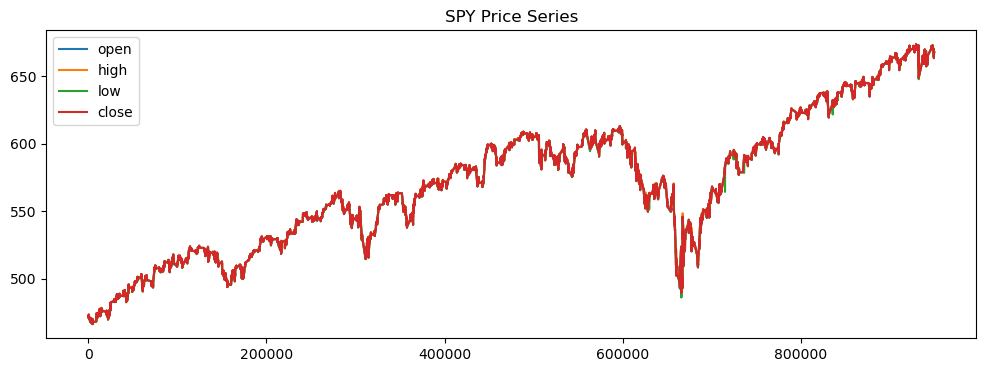

In [13]:
SPY_intraday_df[['open','high','low','close']].plot(figsize=(12,4), title='SPY Price Series')
plt.show()


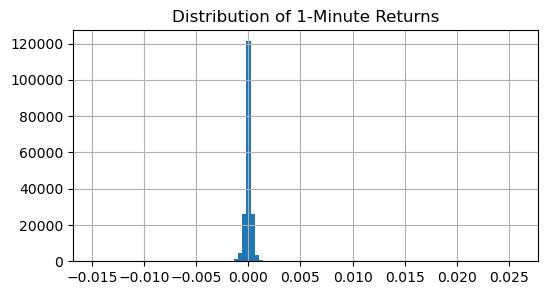

In [14]:
SPY_intraday_df['ret'].hist(bins=100, figsize=(6,3))
plt.title("Distribution of 1-Minute Returns")
plt.show()


In [15]:
z_scores = np.abs((SPY_intraday_df['ret'] - SPY_intraday_df['ret'].mean()) / SPY_intraday_df['ret'].std())
outliers = SPY_intraday_df[z_scores > 5]  # 5 std deviations away
print(f"Outliers detected: {len(outliers)}")
outliers.head()


Outliers detected: 704


,timestamp_utc,open,high,low,close,volume,vwap,ret,vol_5m,vol_30m
20580,2024-01-16 16:00:00+00:00,476.210,476.390,474.9900,475.1650,906131.0,475.6499,-0.002153,0.000897,0.000461
42360,2024-01-31 19:00:00+00:00,487.430,487.830,486.1362,486.3100,1009863.0,486.7795,-0.002298,0.001025,0.000456
45164,2024-02-02 17:44:00+00:00,493.710,493.725,492.4900,492.7499,1001202.0,492.0241,-0.001924,0.000758,0.000483
65447,2024-02-16 19:47:00+00:00,501.285,501.288,500.2550,500.2700,418644.0,500.7504,-0.002015,0.000871,0.000435
84239,2024-02-29 20:59:00+00:00,509.470,509.470,507.9400,508.0000,4610195.0,508.7111,-0.002905,0.001515,0.000626


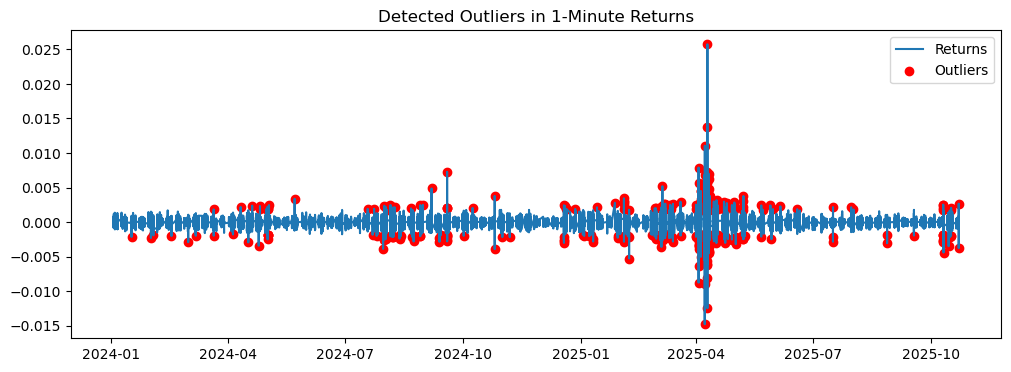

In [16]:
plt.figure(figsize=(12,4))
plt.plot(SPY_intraday_df['timestamp_utc'], SPY_intraday_df['ret'], label='Returns')
plt.scatter(outliers['timestamp_utc'], outliers['ret'], color='red', label='Outliers')
plt.title('Detected Outliers in 1-Minute Returns')
plt.legend()
plt.show()


# Compare Cleaned Dataset vs Old Dataset

In [17]:
# Compare before vs. after
print("Original rows:", len(raw_SPY_intraday_df))
print("Cleaned rows:", len(SPY_intraday_df))
print("Added rows (filled):", len(SPY_intraday_df) - len(raw_SPY_intraday_df))

print("\nOriginal range:", raw_SPY_intraday_df['timestamp_utc'].min(), "→", raw_SPY_intraday_df['timestamp_utc'].max())
print("New range:", SPY_intraday_df['timestamp_utc'].min(), "→", SPY_intraday_df['timestamp_utc'].max())


Original rows: 365406
Cleaned rows: 184552
Added rows (filled): -180854

Original range: 2024-01-02 09:00:00+00:00 → 2025-10-22 23:59:00+00:00
New range: 2024-01-02 14:30:00+00:00 → 2025-10-22 21:00:00+00:00


# Export Cleaned Dataset


In [18]:
SPY_intraday_df.to_csv("SPY_intraday_cleaned.csv", index=False)

# Exploratory Data Analysis

## Price History


### Close Price History

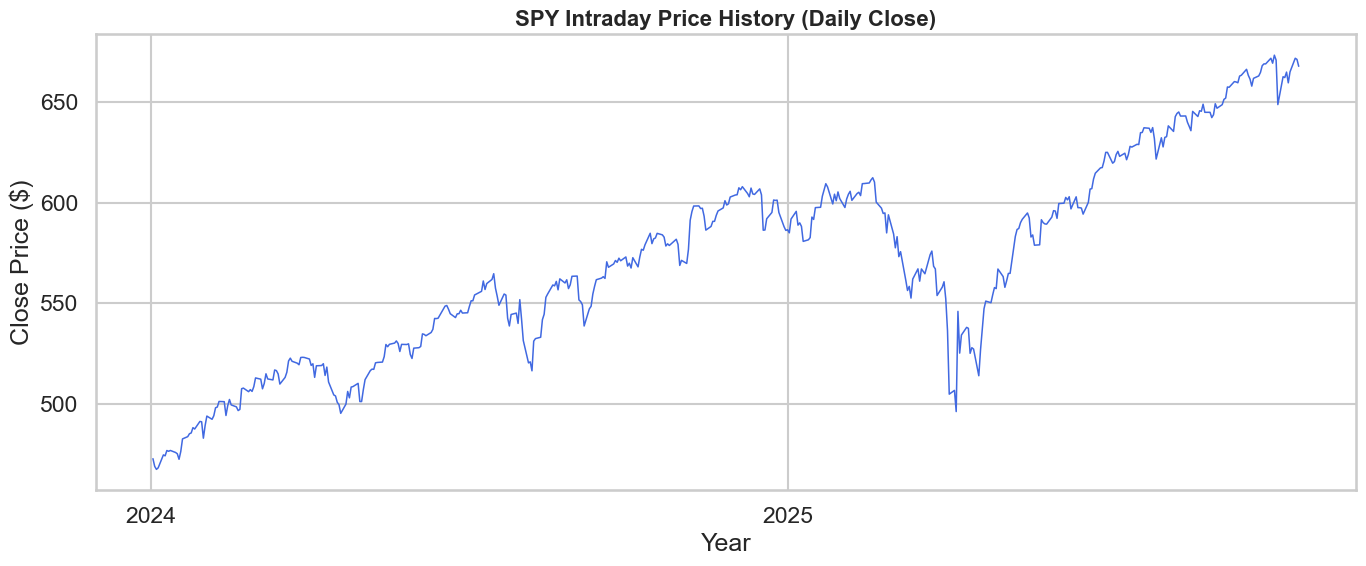

In [19]:
# Set timestamp as index
SPY_intraday_df = SPY_intraday_df.set_index('timestamp_utc')

# Downsample to daily frequency (take last close per day)
SPY_daily = SPY_intraday_df['close'].resample('1D').last().dropna()

# Plot daily close price
sns.set(style="whitegrid", context="talk")

plt.figure(figsize=(14, 6))
sns.lineplot(x=SPY_daily.index, y=SPY_daily.values, color='royalblue', linewidth=1.1)

# Format x-axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=0)

# Titles and labels
plt.title("SPY Intraday Price History (Daily Close)", fontsize=16, weight='bold')
plt.xlabel("Year")
plt.ylabel("Close Price ($)")
plt.tight_layout()
plt.show()


## Regime analysis

### PCA and K-means Regime

c:\Users\malcolm\anaconda3\envs\fins3666\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
c:\Users\malcolm\anaconda3\envs\fins3666\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


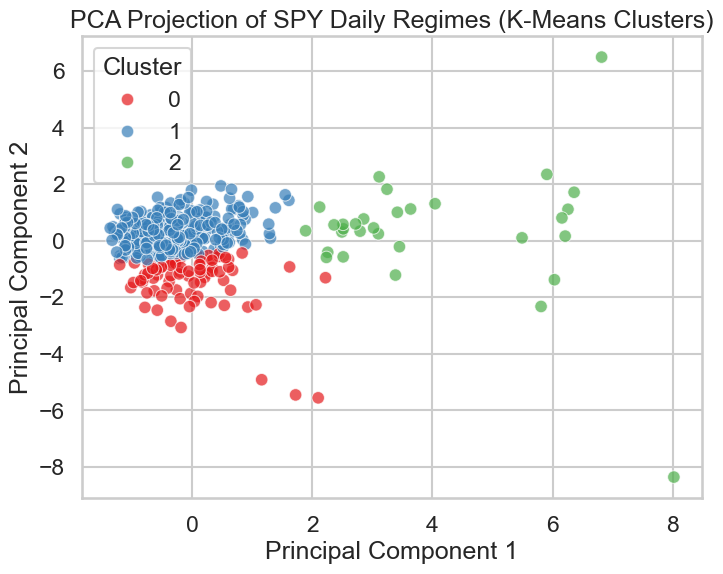

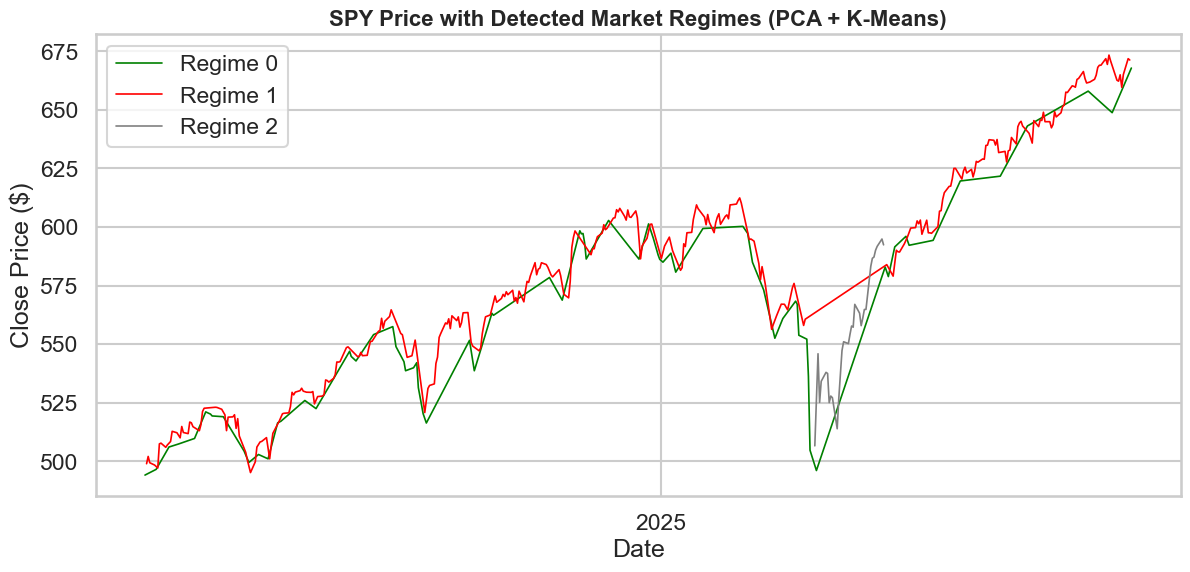

In [20]:
sns.set(style="whitegrid", context="talk")

# Create daily close + volume bars ---
SPY_daily = (
    SPY_intraday_df
    .resample('1D')
    .agg({'close':'last', 'volume':'sum'})
    .dropna()
)

# Feature Engineering ---
SPY_daily['log_return'] = np.log(SPY_daily['close'] / SPY_daily['close'].shift(1))
SPY_daily['volatility_10'] = SPY_daily['log_return'].rolling(10).std()
SPY_daily['volatility_30'] = SPY_daily['log_return'].rolling(30).std()
SPY_daily['volume_change'] = SPY_daily['volume'].pct_change()
SPY_daily['autocorr_5'] = SPY_daily['log_return'].rolling(5).apply(lambda x: x.autocorr(), raw=False)

# Clean + Prepare Feature Matrix ---
SPY_features = SPY_daily[['log_return', 'volatility_10', 'volatility_30', 'volume_change', 'autocorr_5']]
SPY_features = SPY_features.replace([np.inf, -np.inf], np.nan).dropna()

# Standardization + PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(SPY_features)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
SPY_features['cluster'] = kmeans.fit_predict(X_pca)

# Merge clusters back to daily data
SPY_daily = SPY_daily.merge(SPY_features['cluster'], left_index=True, right_index=True, how='left')

# PCA visualization
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=SPY_features['cluster'], palette='Set1', alpha=0.7)
plt.title("PCA Projection of SPY Daily Regimes (K-Means Clusters)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

# Time-series regime visualization
colors = {0:'green', 1:'red', 2:'gray'}
plt.figure(figsize=(14,6))
for cluster, color in colors.items():
    mask = SPY_daily['cluster'] == cluster
    plt.plot(SPY_daily.index[mask], SPY_daily['close'][mask], color=color, label=f'Regime {cluster}', linewidth=1.2)

plt.title("SPY Price with Detected Market Regimes (PCA + K-Means)", fontsize=16, weight='bold')
plt.xlabel("Date")
plt.ylabel("Close Price ($)")
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()


In [21]:
# Summarise Regime Characteristics
regime_summary = (
    SPY_daily
    .groupby('cluster')
    .agg(
        mean_return=('log_return', 'mean'),
        vol_10=('volatility_10', 'mean'),
        vol_30=('volatility_30', 'mean'),
        mean_volume_change=('volume_change', 'mean'),
        n_days=('close', 'count')
    )
    .sort_values('mean_return', ascending=False)
)

print("=== Regime Summary ===")
display(regime_summary)


=== Regime Summary ===


,mean_return,vol_10,vol_30,mean_volume_change,n_days
cluster,,,,,
2.0,0.005846,0.022053,0.025431,20.985084,31
1.0,0.002554,0.007150,0.007606,0.422995,333
0.0,-0.009541,0.009348,0.008377,23.566576,78


### Markov Regime Switching Model

In [22]:
# Compute daily log returns ---
if isinstance(SPY_daily, pd.DataFrame) and 'close' in SPY_daily:
    ret = np.log(SPY_daily['close'] / SPY_daily['close'].shift(1))
else:
    ret = np.log(SPY_daily / SPY_daily.shift(1))

ret = ret.dropna()
ret = pd.Series(ret.values, index=ret.index, name='log_ret')

# Fit Markov Regime-Switching Model
mod = sm.tsa.MarkovRegression(ret, k_regimes=2, trend='c', switching_variance=True)
res = mod.fit(em_iter=50, search_reps=20)
print(res.summary())

#  Extract regime parameters (means & variances)
means = [res.params[i] for i, n in enumerate(res.model.param_names) if 'const' in n]
variances = [res.params[i] for i, n in enumerate(res.model.param_names) if 'sigma2' in n]

# Identify which regime is high-vol (larger variance)
high_vol_state = int(np.argmax(variances))
low_vol_state = 1 - high_vol_state

print("\nEstimated Regime Statistics:")
print(f"Regime 0 → mean={means[0]:.6f}, var={variances[0]:.8f}")
print(f"Regime 1 → mean={means[1]:.6f}, var={variances[1]:.8f}")
print(f"\nHigh-volatility regime: {high_vol_state}")

c:\Users\malcolm\anaconda3\envs\fins3666\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                        Markov Switching Model Results                        
Dep. Variable:                log_ret   No. Observations:                  471
Model:               MarkovRegression   Log Likelihood                1586.488
Date:                Sat, 08 Nov 2025   AIC                          -3160.977
Time:                        21:16:44   BIC                          -3136.048
Sample:                    01-03-2024   HQIC                         -3151.170
                         - 10-22-2025                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0020      0.002     -0.829      0.407      -0.007       0.003
sigma2         0.0004   9.18e-05      4.505      0.0

C:\Users\malcolm\AppData\Local\Temp\ipykernel_28720\2242270360.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  means = [res.params[i] for i, n in enumerate(res.model.param_names) if 'const' in n]
C:\Users\malcolm\AppData\Local\Temp\ipykernel_28720\2242270360.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  variances = [res.params[i] for i, n in enumerate(res.model.param_names) if 'sigma2' in n]


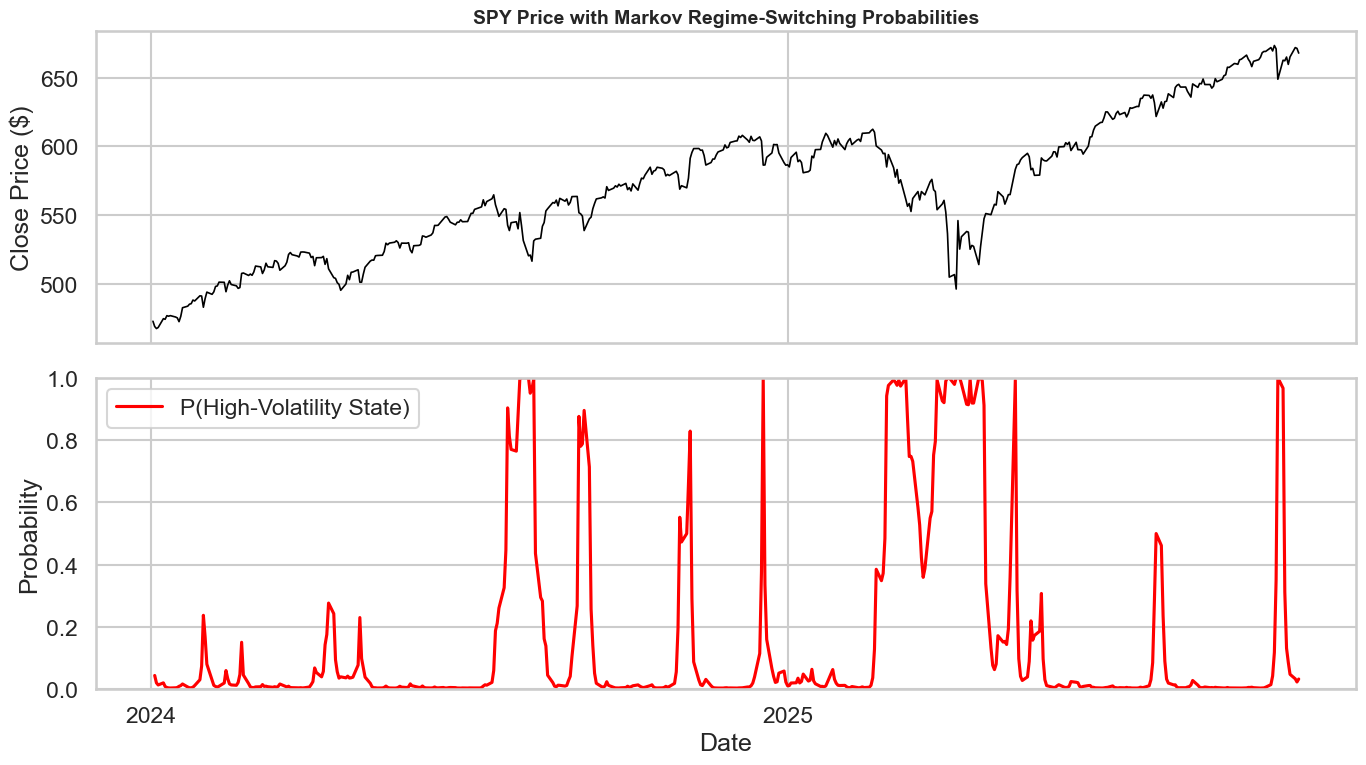

In [23]:
# Extract regime probabilities ---
probs = res.smoothed_marginal_probabilities
prob_highvol = probs[high_vol_state]

fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Price
ax[0].plot(SPY_daily.index, SPY_daily['close'] if 'close' in SPY_daily else SPY_daily,
           color='black', linewidth=1.2)
ax[0].set_title("SPY Price with Markov Regime-Switching Probabilities", fontsize=14, weight='bold')
ax[0].set_ylabel("Close Price ($)")
ax[0].grid(True)

# Regime Probability
ax[1].plot(prob_highvol.index, prob_highvol, color='red', label='P(High-Volatility State)')
ax[1].set_ylim(0, 1)
ax[1].set_ylabel("Probability")
ax[1].set_xlabel("Date")
ax[1].legend(loc='upper left')
ax[1].xaxis.set_major_locator(mdates.YearLocator())
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax[1].grid(True)

plt.tight_layout()
plt.show()

## Volume and Volatility Dynamics

Volatility

In [24]:
SPY_intraday_df["timestamp_utc"] = pd.to_datetime(SPY_intraday_df["timestamp_utc"], utc=True, errors="coerce")
SPY_intraday_df = SPY_intraday_df.dropna(subset=["timestamp_utc"]).sort_values("timestamp_utc")
SPY_intraday_df = SPY_intraday_df.set_index("timestamp_utc")
SPY_intraday_df["vol_30m"] = SPY_intraday_df["ret"].rolling("30min").std()

plt.figure(figsize=(12,4))
SPY_intraday_df["vol_30m"].plot()
plt.title("SPY 30-min Rolling Volatility")
plt.xlabel("Time (UTC)")
plt.ylabel("30-min std of returns")
plt.tight_layout()
plt.show()

KeyError: 'timestamp_utc'

Volume

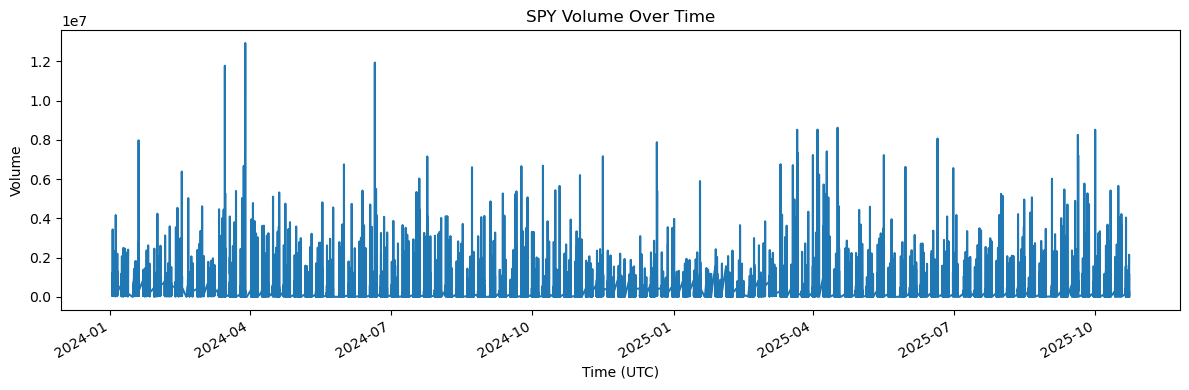

In [ ]:
plt.figure(figsize = (12,4))
SPY_intraday_df["volume"].plot()
plt.title("SPY Volume Over Time")
plt.xlabel("Time (UTC)")
plt.ylabel("Volume")
plt.tight_layout()
plt.show()

Intraday Volume Pattern

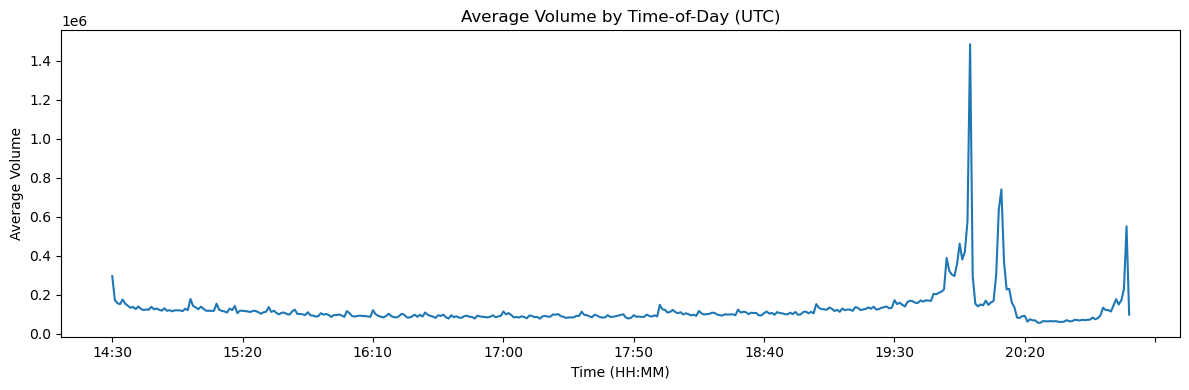

In [ ]:
intraday_vol = (
    SPY_intraday_df
    .groupby([SPY_intraday_df.index.hour, SPY_intraday_df.index.minute])["volume"]
    .mean()
)

intraday_vol.index = [f"{h:02d}:{m:02d}" for (h, m) in intraday_vol.index]  # HH:MM UTC

plt.figure(figsize=(12,4))
intraday_vol.plot()
plt.title("Average Volume Traded by Time-of-Day (EST)") #TODO: need to factor in DST
plt.xlabel("Time of the day")
plt.ylabel("Average Volume")
plt.tight_layout()
plt.show()


Volume-Volatility

In [ ]:
SPY_intraday_df["abs_ret"] = SPY_intraday_df["ret"].abs()
corr = SPY_intraday_df[["abs_ret", "volume"]].corr().loc["volume", "abs_ret"]
print("Correlation between return and volume:", corr)


Correlation between return and volume: 0.22825123314372253


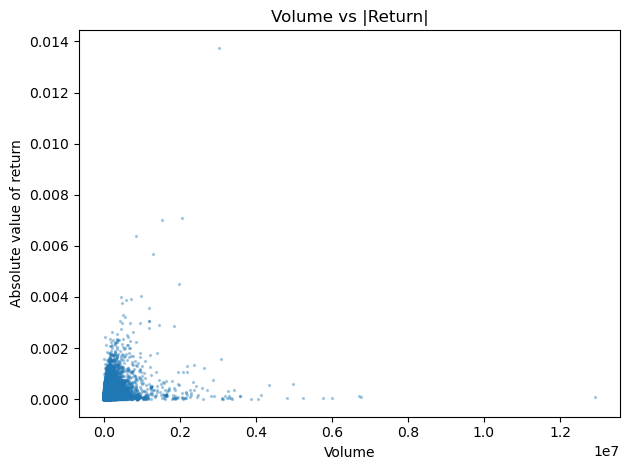

In [ ]:
sample = SPY_intraday_df.sample(min(20000, len(SPY_intraday_df)), random_state=0)  # thin if huge
plt.figure()
plt.scatter(sample["volume"], sample["abs_ret"], s=2, alpha=0.3)
plt.title("Volume vs |Return|")
plt.xlabel("Volume")
plt.ylabel("Absolute value of return")
plt.tight_layout()
plt.show()


## Descriptive Statistics

mean, std, skew, kurtosis, rolling vol, etc.

In [ ]:
ret = SPY_intraday_df["ret"].dropna()

print("=== Return stats ===")
print(ret.describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]))
print("Mean (per interval):", ret.mean())
print("Std  (per interval):", ret.std())
print("Skew:", ret.skew())
print("Kurtosis:", ret.kurt())


=== Return stats ===
count    184552.000000
mean          0.000001
std           0.000357
min          -0.014788
1%           -0.000995
5%           -0.000486
50%           0.000000
95%           0.000462
99%           0.000930
max           0.025744
Name: ret, dtype: float64
Mean (per interval): 1.2829684476062662e-06
Std  (per interval): 0.0003566986498371578
Skew: 2.0081033613026333
Kurtosis: 220.7643762456308


## Inferential checks
correlations, t-tests, OLS regressions (e.g. return ~ sentiment)

## Stationarity tests

## Lag significance tests

## Normality and Distribution Checks

# Export Data